In [37]:
import pandas as pd
import language_tool_python
import numpy as np

In [38]:
data = pd.read_csv('./train.csv')

In [39]:
from sklearn.model_selection import train_test_split
x_train, x_test,y_train,y_test = train_test_split(data, data, test_size = 0.3,random_state=50)


In [40]:
def grammarcheck(df):
    tool = language_tool_python.LanguageTool('en-US')
    counts = {'counts':{},'score':{}}
    rules = {}
    for i in df.index:
        matches = tool.check(df['full_text'][i])
        counts['counts'][i] = len(matches)
        counts['score'][i] = (str(df['grammar'][i]))
        rules[i] = {}
        for m in matches:
            if m.ruleId in rules[i].keys():
                rules[i][m.ruleId] += 1
            else:
                rules[i][m.ruleId] = 1
    return counts, rules

In [66]:
def ruleCheck(rules,test=None):
    all_rules = []
    for i in rules.keys():
        for j in rules[i].keys():
            if j not in all_rules:
                all_rules.append(j)
    data = pd.DataFrame(0, index=rules.keys(),columns=all_rules)
    if test == None:
        for i in rules.keys():
            for j in rules[i].keys():
                data[j][i] = rules[i][j]
    if test != None:
        for i in test.keys():
            for j in test[i].keys():
                if j in all_rules:
                    data[j][i] = test[i][j]
    return data

In [42]:

def getAvg(counts):
    sums = {"1.0":0,
    "1.5":0,
    "2.0":0,
    "2.5":0,
    "3.0":0,
    "3.5":0,
    "4.0":0,
    "4.5":0,
    "5.0":0}
    n = {"1.0":0,
    "1.5":0,
    "2.0":0,
    "2.5":0,
    "3.0":0,
    "3.5":0,
    "4.0":0,
    "4.5":0,
    "5.0":0}
    avg = {}
    for i in counts['counts'].keys():
        sums[counts['score'][i]] += counts['counts'][i]
        n[counts['score'][i]] += 1
        
    for sum in sums.keys():
        avg[sum] = (sums[sum])/(n[sum])
    return avg

In [43]:

def getMost(counts):
    sums = {"1.0":[],
    "1.5":[],
    "2.0":[],
    "2.5":[],
    "3.0":[],
    "3.5":[],
    "4.0":[],
    "4.5":[],
    "5.0":[]}
    n = {"1.0":0,
    "1.5":0,
    "2.0":0,
    "2.5":0,
    "3.0":0,
    "3.5":0,
    "4.0":0,
    "4.5":0,
    "5.0":0}
    avg = {}
    for i in counts['counts'].keys():
        sums[counts['score'][i]].append(counts['counts'][i])
            
        
    
    return sums

In [44]:
counts,rules = grammarcheck(x_train)


In [60]:
a = ruleCheck(rules)
print(a)

      IN_THIS_MOMENT  MORFOLOGIK_RULE_EN_US  FOCUS_IN  \
889                1                      9         1   
3180               0                      2         0   
123                0                     14         2   
307                0                      0         0   
453                0                      9         0   
...              ...                    ...       ...   
1898               0                      0         0   
1945               0                      0         0   
3818               0                      0         0   
300                0                      0         0   
934                0                     15         0   

      COMMA_PARENTHESIS_WHITESPACE  ENGLISH_WORD_REPEAT_RULE  \
889                              1                         1   
3180                             1                         0   
123                              1                         0   
307                              0                         

In [46]:

avg = getAvg(counts)

In [47]:
def grammarScoring(avg, test):
    gScores = {}
    testCount,rules = grammarcheck(test)
    
    for ind in testCount['counts'].keys():
        val = testCount['counts'][ind]
        if val <= avg["5.0"]:
            gScores[ind] = 5.0
        elif val > avg["5.0"] and  val <= avg["4.5"]:
            gScores[ind] = 4.5
        elif val > avg["4.5"] and  val <= avg["4.0"]:
            gScores[ind] = 4.0
        elif val > avg["4.0"] and  val <= avg["3.5"]:
            gScores[ind] = 3.5
        elif val > avg["3.5"] and  val <= avg["3.0"]:
            gScores[ind] = 3.0
        elif val > avg["3.0"] and  val <= avg["2.5"]:
            gScores[ind] =2.5
        elif val > avg["2.5"] and  val <= avg["2.0"]:
            gScores[ind] =2.0
        elif val > avg["2.0"] and  val <= avg["1.5"]:
            gScores[ind] =1.5
        else:
            gScores[ind] = 1.0
        

    return gScores,rules

In [48]:
def score_split(scores):
    keys = []
    val = []
    for k in scores.keys():
        keys.append(k)
        val.append(scores[k])
    return keys, val

In [49]:
train_gscores,train_r = grammarScoring(avg, x_train)
test_gscores,test_r = grammarScoring(avg, x_test)

In [67]:
a = ruleCheck(train_r)
b = ruleCheck(train_r,test=test_r)

In [51]:
avg

{'1.0': 71.33333333333333,
 '1.5': 43.4,
 '2.0': 33.28051948051948,
 '2.5': 27.087314662273474,
 '3.0': 23.034433285509326,
 '3.5': 19.28026533996683,
 '4.0': 16.08026755852843,
 '4.5': 12.66,
 '5.0': 14.56}

In [52]:
sum = getMost(counts)

In [53]:
from statistics import mode
mode(sum['5.0'])
print(sum["5.0"])

[7, 17, 12, 6, 8, 14, 9, 8, 9, 28, 13, 3, 5, 6, 119, 4, 8, 15, 15, 17, 8, 9, 14, 6, 4]


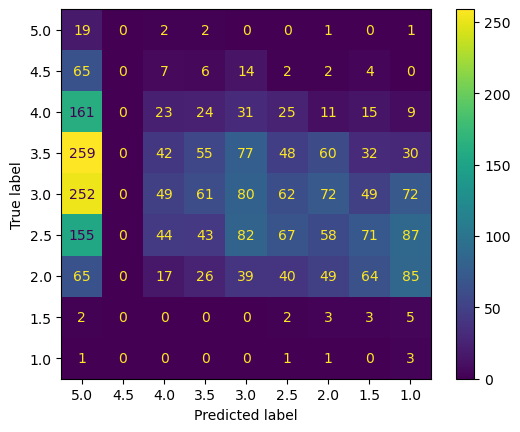

0.1092436974789916


In [54]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
key, val = score_split(train_gscores)
res = pd.Series(train_gscores)
res = res.astype("string")
tru = x_train["grammar"].astype("string")
label=["5.0", "4.5", "4.0","3.5","3.0","2.5","2.0","1.5","1.0"]
confusion_matrix = metrics.confusion_matrix(tru, res,labels=label)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = label)

cm_display.plot()
plt.show()
Accuracy = metrics.accuracy_score(tru, res)
print(Accuracy)


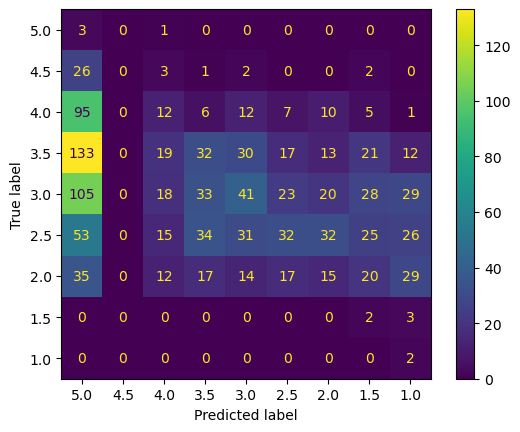

0.11839863713798977


In [55]:
res = pd.Series(test_gscores)
res = res.astype("string")
tru = x_test["grammar"].astype("string")
confusion_matrix = metrics.confusion_matrix(tru, res,labels=label)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = label)

cm_display.plot()
plt.show()
Accuracy = metrics.accuracy_score(tru, res)
print(Accuracy)


In [68]:
from sklearn.naive_bayes import GaussianNB
train = pd.Series(counts["counts"])
train = train.astype("string")
train = train.to_numpy()
train = train.reshape(-1, 1)
ty = pd.Series(counts["score"])
ty = ty.astype("string")

tc,rules = grammarcheck(x_test)
test =  pd.Series(tc["counts"])
test = test.astype("string")
test = test.to_numpy()
test = test.reshape(-1, 1)
gnb = GaussianNB()
y_pred = gnb.fit(train, ty).predict(test)
gnb_rule = GaussianNB()
ryp = gnb_rule.fit(a,ty).predict(b)



In [73]:
x_test["grammar"].astype("string").shape

(1174,)

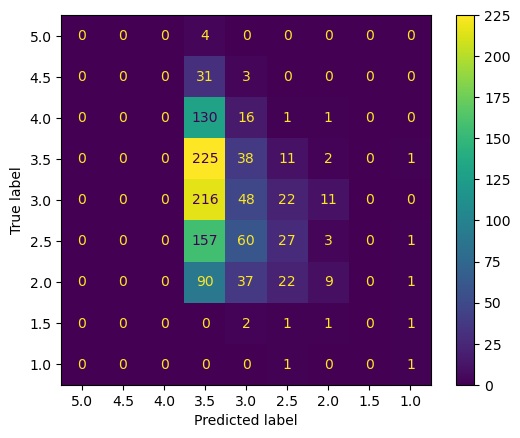

0.26405451448040884


In [ ]:
tru = x_test["grammar"].astype("string")
confusion_matrix = metrics.confusion_matrix(tru, y_pred,labels=label)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = label)

cm_display.plot()
plt.show()
Accuracy = metrics.accuracy_score(tru, y_pred)
print(Accuracy)
#rint(gnb.score())


In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
clf = clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
#clf = SVC(gamma='auto')
clf.fit(train, ty)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [ ]:
pre_y = clf.predict(test)

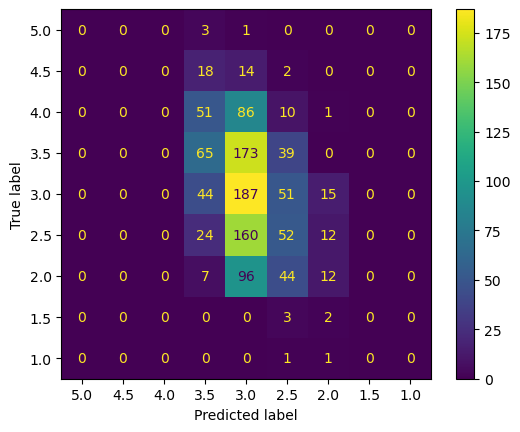

0.26916524701873934


In [ ]:
confusion_matrix = metrics.confusion_matrix(tru, pre_y,labels=label)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = label)

cm_display.plot()
plt.show()
Accuracy = metrics.accuracy_score(tru, pre_y)
print(Accuracy)